## A1. Research Question
Can the amount of bandwidth used by a customer per year be predicted based upon other variables?

## A2. Objectives and Goals
The objective of this analysis is to produce a multiple regression model that can predict the amount of bandwidth a customer will use in the future. 

## B1. Summary of Assumptions
[1]

1. Regression residuals must be normally distributed.

2. A linear relationship is assumed between the dependent variable and the independent variables.

3. The residuals are homoscendastic and approximately rectangular-shaped.

4. Abscence of multicollinearity is expected in the model, meaning that the independent variables are not too highly correlated.

5. No autocorrelation of the residuals.

## B2. Tool Benefits
I chose python for this task because of its ease of use, simplicity, and relevant packages. The specific packages chosen make performing multiple linear regression very simple and provide informative statistical outputs. Additionally, some of the packages are very helpful for creating visualizations that can aid in a more intuitive analysis.

## B3. Appropriate Technique
Multiple regression analysis is the appropriate approach due to both the number of variables and the data types of those variables. Because this data set contains many potential explanatory variables, a simple linear regression might not explain the dependent variable as well as analyze many variables. Additionally, the response variable in this analysis is continuous, requiring linear analysis instead of logistic analysis.

## C1. Data Goals
1. Verify that the provided data set is "clean" and has no missing values.
2. Determine if any columns would make no logical sense to keep for the analysis and drop them.
3. Transform any remaining variables that are not continuous to something that can be used in a regression model.

# C2. Summary Statistics
The first summary to look at is the data types for each column so that we know both if the dependent variable chosen is the appropriate type and also if there are any strings that can be quickly dropped. Next, it is essential to look at the head or column names and their first few values. This makes it easy to quickly look through and logically deduce if a variable is relevant to the question. Variables such as zip code and time zone likely have little to no effect and would only further complicate the analysis if kept.

The data types present in this data set include integers, floats, and object types. Unfortunately, from just looking at that, it is not clear which object type variables contain true/false values and which contain strings that can't be used in this analysis. Instead, the head of the data needs to be reviewed. The target variable is a float, and from the first few visible entries, you can see it is continuous, which is needed for this type of regression. For the predictor variables, integers/floats can be kept if they meet the above logic requirements. This means removing CaseOrder, Zip, Lat, Lng, Population, and Item1-Item8. Looking then at the remaining object variables, all of the ones containing strings that are not limited to Yes/No (True/False) can also be removed. This includes Customer_id, Interaction, UID, City, State, County, Area, TimeZone, Job, Marital, Gender, and PaymentMethod.

After going through the summary outputs, the data set is limited to a target variable that is a continuous float and predictor variables that are floats/integers or are True/False responses that can be converted to boolean values.

Using the .describe function, we can look at the basic statistics of the data set to get a sense of the shape of the data and some general insights that might be useful for variable selection (displayed below). For the continuous variables, the focus is on the mean, min, max, and standard deviation. Those four outputs can give a rough idea of distributions and potential outliers that might affect later analysis. With the true/false variables, the summary shows which response was most frequent and how often it occurred. A column that is completely limited to one response might not be a good choice to keep for analysis because you would have no data for the other response to create predictions from.

Specifically looking at the target variable Bandwidth_GB_Year, it has a mean of 3392, minimum of 155, max of 7159, and a standard deviation of 2185. From this we can deduce that all of the values present fall within two standard deviations of the mean, signaling a lack of excessive outliers. Later during the model evaluation, if predictions fall significantly outside this range, it might indicate some hidden issue in the model itself that needs to be addressed.

Of the remaining continuous variables, only Age and Tenure don't have significant outliers beyond 2 standard deviations of the mean. While this might be significant, those columns will be kept for the analysis unless there is a specific reason for removal (such as heavily skewing the model). For the categorical True/False columns, all of them except for Techie have nearly even distributions of true/false. Even though Techie is skewed towards False, there are still close to 2,000 True responses, providing enough distribution to be relevant later. 

## C3. Steps to Prepare the Data
1. Drop columns containing strings or other data that generally seem unlikely to affect the response variable.
2. Replace Yes/No responses with boolean True/False values.
3. Check for missing values and remove them.

In [1]:
#Import relevant tools
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import describe

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from yellowbrick.regressor import AlphaSelection, PredictionError, ResidualsPlot
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV

In [2]:
#Import the Dataset
churn_df = pd.read_csv('C:/Users/Conner/OneDrive/WGU/D208/churn_clean.csv')

In [3]:
#Display the data types of each column
churn_df.dtypes

CaseOrder                 int64
Customer_id              object
Interaction              object
UID                      object
City                     object
State                    object
County                   object
Zip                       int64
Lat                     float64
Lng                     float64
Population                int64
Area                     object
TimeZone                 object
Job                      object
Children                  int64
Age                       int64
Income                  float64
Marital                  object
Gender                   object
Churn                    object
Outage_sec_perweek      float64
Email                     int64
Contacts                  int64
Yearly_equip_failure      int64
Techie                   object
Contract                 object
Port_modem               object
Tablet                   object
InternetService          object
Phone                    object
Multiple                 object
OnlineSe

In [4]:
churn_df.head()

,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,...,MonthlyCharge,Bandwidth_GB_Year,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
0,1,K409198,aa90260b-4141-4a24-8e36-b04ce1f4f77b,e885b299883d4f9fb18e39c75155d990,Point Baker,AK,Prince of Wales-Hyder,99927,56.25100,-133.37571,...,172.455519,904.536110,5,5,5,3,4,4,3,4
1,2,S120509,fb76459f-c047-4a9d-8af9-e0f7d4ac2524,f2de8bef964785f41a2959829830fb8a,West Branch,MI,Ogemaw,48661,44.32893,-84.24080,...,242.632554,800.982766,3,4,3,3,4,3,4,4
2,3,K191035,344d114c-3736-4be5-98f7-c72c281e2d35,f1784cfa9f6d92ae816197eb175d3c71,Yamhill,OR,Yamhill,97148,45.35589,-123.24657,...,159.947583,2054.706961,4,4,2,4,4,3,3,3
3,4,D90850,abfa2b40-2d43-4994-b15a-989b8c79e311,dc8a365077241bb5cd5ccd305136b05e,Del Mar,CA,San Diego,92014,32.96687,-117.24798,...,119.956840,2164.579412,4,4,4,2,5,4,3,3
4,5,K662701,68a861fd-0d20-4e51-a587-8a90407ee574,aabb64a116e83fdc4befc1fbab1663f9,Needville,TX,Fort Bend,77461,29.38012,-95.80673,...,149.948316,271.493436,4,4,4,3,4,4,4,5


In [5]:
#Drop columns that are not continuous variables, can be converted to boolean values, or are otherwise not logical
churn_df = churn_df.drop(['Population', 'CaseOrder', 'Customer_id', 'Interaction', 'UID', 'City', 'State', 'County', 'Zip', 'Lat', 'Lng', 'Area', 'TimeZone', 'Job', 'Marital', 'Gender', 'Contract', 'InternetService', 'PaymentMethod', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8'], axis = 1)

In [6]:
churn_df.describe(include = 'all')

,Children,Age,Income,Churn,Outage_sec_perweek,Email,Contacts,Yearly_equip_failure,Techie,Port_modem,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,Tenure,MonthlyCharge,Bandwidth_GB_Year
count,10000.0000,10000.000000,10000.000000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000,10000,...,10000,10000,10000,10000,10000,10000,10000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,2,2,...,2,2,2,2,2,2,2,NaN,NaN,NaN
top,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,No,No,...,No,No,No,No,No,No,Yes,NaN,NaN,NaN
freq,NaN,NaN,NaN,7350,NaN,NaN,NaN,NaN,8321,5166,...,6424,5494,5614,6250,5071,5110,5882,NaN,NaN,NaN
mean,2.0877,53.078400,39806.926771,NaN,10.001848,12.016000,0.994200,0.398000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.526188,172.624816,3392.341550
std,2.1472,20.698882,28199.916702,NaN,2.976019,3.025898,0.988466,0.635953,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.443063,42.943094,2185.294852
min,0.0000,18.000000,348.670000,NaN,0.099747,1.000000,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000259,79.978860,155.506715
25%,0.0000,35.000000,19224.717500,NaN,8.018214,10.000000,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.917694,139.979239,1236.470827
50%,1.0000,53.000000,33170.605000,NaN,10.018560,12.000000,1.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.430507,167.484700,3279.536903
75%,3.0000,71.000000,53246.170000,NaN,11.969485,14.000000,2.000000,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.479795,200.734725,5586.141369


In [7]:
#Check for missing values
churn_df.isnull().sum()

Children                0
Age                     0
Income                  0
Churn                   0
Outage_sec_perweek      0
Email                   0
Contacts                0
Yearly_equip_failure    0
Techie                  0
Port_modem              0
Tablet                  0
Phone                   0
Multiple                0
OnlineSecurity          0
OnlineBackup            0
DeviceProtection        0
TechSupport             0
StreamingTV             0
StreamingMovies         0
PaperlessBilling        0
Tenure                  0
MonthlyCharge           0
Bandwidth_GB_Year       0
dtype: int64

In [8]:
#Replace No/Yes responses with boolean values.
churn_df['Churn'] = churn_df['Churn'] == 'Yes'
churn_df['Techie'] = churn_df['Techie'] == 'Yes'
churn_df['Port_modem'] = churn_df['Port_modem'] == 'Yes'
churn_df['Tablet'] = churn_df['Tablet'] == 'Yes'
churn_df['Phone'] = churn_df['Phone'] == 'Yes'
churn_df['Multiple'] = churn_df['Multiple'] == 'Yes'
churn_df['OnlineSecurity'] = churn_df['OnlineSecurity'] == 'Yes'
churn_df['OnlineBackup'] = churn_df['OnlineBackup'] == 'Yes'
churn_df['DeviceProtection'] = churn_df['DeviceProtection'] == 'Yes'
churn_df['TechSupport'] = churn_df['TechSupport'] == 'Yes'
churn_df['StreamingTV'] = churn_df['StreamingTV'] == 'Yes'
churn_df['StreamingMovies'] = churn_df['StreamingMovies'] == 'Yes'
churn_df['PaperlessBilling'] = churn_df['PaperlessBilling'] == 'Yes'

## C4. Visualizations

<AxesSubplot:title={'center':'Bandwidth_GB_Year'}, ylabel='Frequency'>

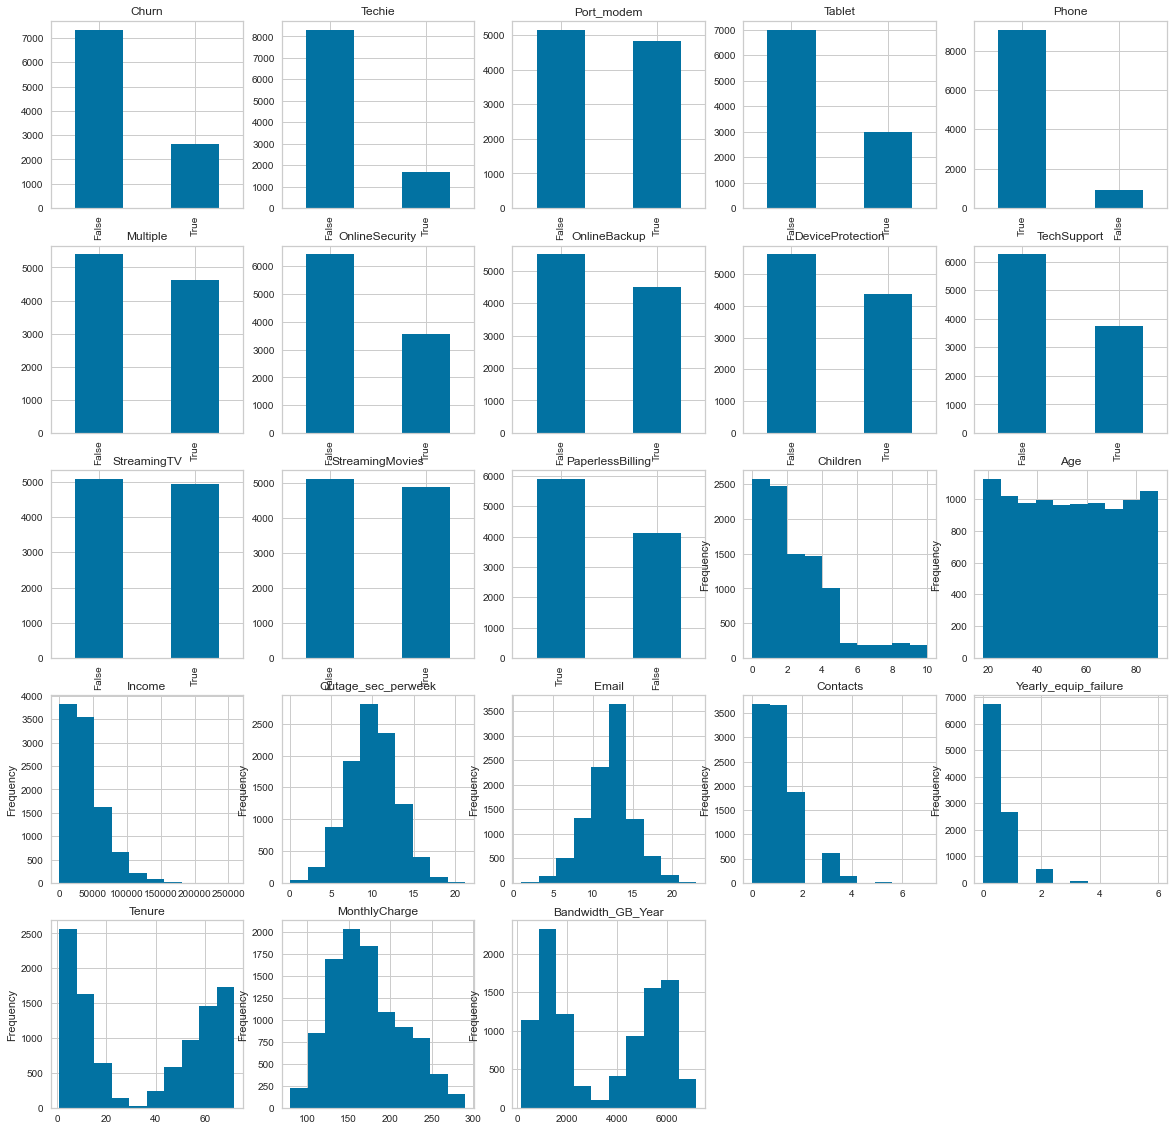

In [9]:
#Univariate visualizations
[2]
fig = plt.figure(figsize=(20,20)) 
fig_dims = (5, 5)

# Plot Boolean variable counts
plt.subplot2grid(fig_dims, (0, 0))
churn_df['Churn'].value_counts().plot(kind = 'bar', title='Churn')

plt.subplot2grid(fig_dims, (0, 1))
churn_df['Techie'].value_counts().plot(kind = 'bar', title='Techie')

plt.subplot2grid(fig_dims, (0, 2))
churn_df['Port_modem'].value_counts().plot(kind = 'bar', title='Port_modem')

plt.subplot2grid(fig_dims, (0, 3))
churn_df['Tablet'].value_counts().plot(kind = 'bar', title='Tablet')

plt.subplot2grid(fig_dims, (0, 4))
churn_df['Phone'].value_counts().plot(kind = 'bar', title='Phone')

plt.subplot2grid(fig_dims, (1, 0))
churn_df['Multiple'].value_counts().plot(kind = 'bar', title='Multiple')

plt.subplot2grid(fig_dims, (1, 1))
churn_df['OnlineSecurity'].value_counts().plot(kind = 'bar', title='OnlineSecurity')

plt.subplot2grid(fig_dims, (1, 2))
churn_df['OnlineBackup'].value_counts().plot(kind = 'bar', title='OnlineBackup')

plt.subplot2grid(fig_dims, (1, 3))
churn_df['DeviceProtection'].value_counts().plot(kind = 'bar', title='DeviceProtection')

plt.subplot2grid(fig_dims, (1, 4))
churn_df['TechSupport'].value_counts().plot(kind = 'bar', title='TechSupport')

plt.subplot2grid(fig_dims, (2, 0))
churn_df['StreamingTV'].value_counts().plot(kind = 'bar', title='StreamingTV')

plt.subplot2grid(fig_dims, (2, 1))
churn_df['StreamingMovies'].value_counts().plot(kind = 'bar', title='StreamingMovies')

plt.subplot2grid(fig_dims, (2, 2))
churn_df['PaperlessBilling'].value_counts().plot(kind = 'bar', title='PaperlessBilling')

#Histograms of continuous variables
plt.subplot2grid(fig_dims, (2, 3))
churn_df['Children'].plot(kind = 'hist', title='Children')

plt.subplot2grid(fig_dims, (2, 4))
churn_df['Age'].plot(kind = 'hist', title='Age')

plt.subplot2grid(fig_dims, (3, 0))
churn_df['Income'].plot(kind = 'hist', title='Income')

plt.subplot2grid(fig_dims, (3, 1))
churn_df['Outage_sec_perweek'].plot(kind = 'hist', title='Outage_sec_perweek')

plt.subplot2grid(fig_dims, (3, 2))
churn_df['Email'].plot(kind = 'hist', title='Email')

plt.subplot2grid(fig_dims, (3, 3))
churn_df['Contacts'].plot(kind = 'hist', title='Contacts')

plt.subplot2grid(fig_dims, (3, 4))
churn_df['Yearly_equip_failure'].plot(kind = 'hist', title='Yearly_equip_failure')

plt.subplot2grid(fig_dims, (4, 0))
churn_df['Tenure'].plot(kind = 'hist', title='Tenure')

plt.subplot2grid(fig_dims, (4, 1))
churn_df['MonthlyCharge'].plot(kind = 'hist', title='MonthlyCharge')

plt.subplot2grid(fig_dims, (4, 2))
churn_df['Bandwidth_GB_Year'].plot(kind = 'hist', title='Bandwidth_GB_Year')

Text(0, 0.5, 'Bandwidth_GB_Year')

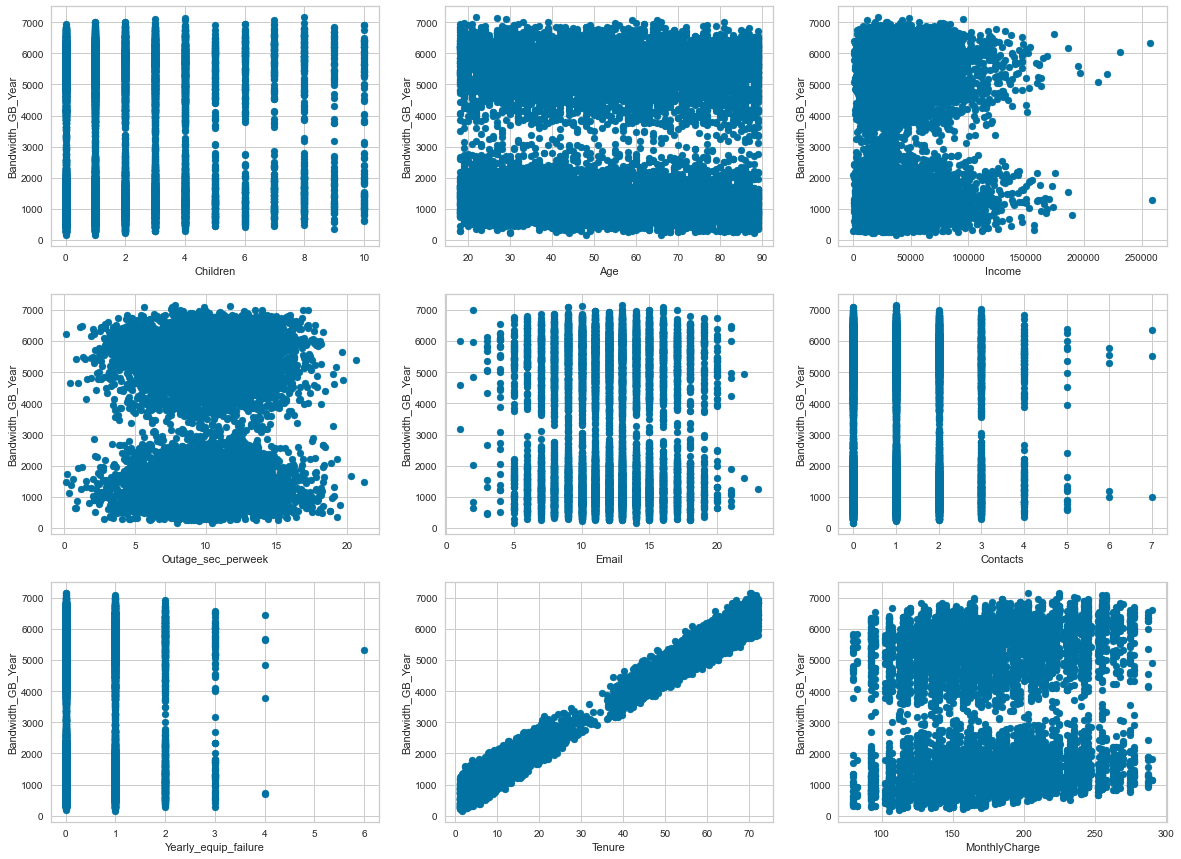

In [10]:
#Create bivariate plots of dependent variable vs all independent continuous variables
[3]
fig, ax = plt.subplots(nrows = 3,ncols = 3,figsize = (20, 15))
dependent_var = churn_df['Bandwidth_GB_Year']
ax[0,0].scatter(x = churn_df['Children'], y = churn_df['Bandwidth_GB_Year'])
ax[0,0].set_xlabel("Children")
ax[0,0].set_ylabel("Bandwidth_GB_Year")

ax[0,1].scatter(x = churn_df['Age'], y = churn_df['Bandwidth_GB_Year'])
ax[0,1].set_xlabel("Age")
ax[0,1].set_ylabel("Bandwidth_GB_Year")

ax[0,2].scatter(x = churn_df['Income'], y = churn_df['Bandwidth_GB_Year'])
ax[0,2].set_xlabel("Income")
ax[0,2].set_ylabel("Bandwidth_GB_Year")

ax[1,0].scatter(x = churn_df['Outage_sec_perweek'], y = churn_df['Bandwidth_GB_Year'])
ax[1,0].set_xlabel("Outage_sec_perweek")
ax[1,0].set_ylabel("Bandwidth_GB_Year")

ax[1,1].scatter(x = churn_df['Email'], y = churn_df['Bandwidth_GB_Year'])
ax[1,1].set_xlabel("Email")
ax[1,1].set_ylabel("Bandwidth_GB_Year")

ax[1,2].scatter(x = churn_df['Contacts'], y = churn_df['Bandwidth_GB_Year'])
ax[1,2].set_xlabel("Contacts")
ax[1,2].set_ylabel("Bandwidth_GB_Year")

ax[2,0].scatter(x = churn_df['Yearly_equip_failure'], y = churn_df['Bandwidth_GB_Year'])
ax[2,0].set_xlabel("Yearly_equip_failure")
ax[2,0].set_ylabel("Bandwidth_GB_Year")

ax[2,1].scatter(x = churn_df['Tenure'], y = churn_df['Bandwidth_GB_Year'])
ax[2,1].set_xlabel("Tenure")
ax[2,1].set_ylabel("Bandwidth_GB_Year")

ax[2,2].scatter(x = churn_df['MonthlyCharge'], y = churn_df['Bandwidth_GB_Year'])
ax[2,2].set_xlabel("MonthlyCharge")
ax[2,2].set_ylabel("Bandwidth_GB_Year")


## C5. Prepared Data Set

In [11]:
churn_df.to_excel("Prepared_churn_data.xlsx")

## D1. Initial Model

In [12]:
#Create an initial multiple regression model
churn_model = smf.ols('Bandwidth_GB_Year ~ Churn + Techie + Port_modem + Tablet + Phone + Multiple + OnlineSecurity + OnlineBackup+ DeviceProtection + TechSupport + StreamingTV + StreamingMovies + PaperlessBilling + Children + Age + Income + Outage_sec_perweek + Email + Contacts + Yearly_equip_failure + Tenure + MonthlyCharge', data = churn_df).fit()
print(churn_model.params)
churn_model.summary()

Intercept                   533.888480
Churn[T.True]                86.889373
Techie[T.True]               -2.934602
Port_modem[T.True]           -2.565031
Tablet[T.True]               -0.664656
Phone[T.True]                -1.578430
Multiple[T.True]            153.547568
OnlineSecurity[T.True]       86.874495
OnlineBackup[T.True]        148.217710
DeviceProtection[T.True]    113.228692
TechSupport[T.True]          42.919764
StreamingTV[T.True]         322.941446
StreamingMovies[T.True]     327.036456
PaperlessBilling[T.True]     -5.982431
Children                     30.631211
Age                          -3.314502
Income                        0.000093
Outage_sec_perweek           -0.640616
Email                         0.000385
Contacts                      2.011887
Yearly_equip_failure          1.547465
Tenure                       82.714528
MonthlyCharge                -2.635337
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Bandwidth_GB_Year   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 5.629e+04
Date:                Thu, 11 Nov 2021   Prob (F-statistic):               0.00
Time:                        16:36:48   Log-Likelihood:                -66938.
No. Observations:               10000   AIC:                         1.339e+05
Df Residuals:                    9977   BIC:                         1.341e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  533.8885     18.790     28.414      0.000     497.057     570.720
Churn[T.True]               86.8894      5.724     15.179      0.000      75.668      98.110
Techie[T.True]              -2.9346      5.254     -0.559      0.576     -13.233       7.364
Port_modem[T.True]          -2.5650      3.916     -0.655      0.513     -10.242       5.112
Tablet[T.True]              -0.6647      4.278     -0.155      0.877      -9.051       7.722
Phone[T.True]               -1.5784      6.735     -0.234      0.815     -14.781      11.624
Multiple[T.True]           153.5476      5.691     26.981      0.000     142.392     164.703
OnlineSecurity[T.True]      86.8745      4.105     21.162      0.000      78.827      94.922
OnlineBackup[T.True]       148.2177      4.832     30.673      0.000     138.746     157.690
DeviceProtection[T.True]   113.2287      4.247     26.661      0.000     104.904     121.554
TechSupport[T.True]         42.9198      4.307      9.965      0.000      34.477      51.363
StreamingTV[T.True]        322.9414      6.593     48.985      0.000     310.018     335.864
StreamingMovies[T.True]    327.0365      7.679     42.589      0.000     311.984     342.089
PaperlessBilling[T.True]    -5.9824      3.978     -1.504      0.133     -13.781       1.816
Children                    30.6312      0.912     33.587      0.000      28.843      32.419
Age                         -3.3145      0.095    -35.028      0.000      -3.500      -3.129
Income                    9.342e-05   6.94e-05      1.346      0.178   -4.26e-05       0.000
Outage_sec_perweek          -0.6406      0.658     -0.974      0.330      -1.930       0.649
Email                        0.0004      0.647      0.001      1.000      -1.268       1.269
Contacts                     2.0119      1.981      1.016      0.310      -1.871       5.895
Yearly_equip_failure         1.5475      3.078      0.503      0.615      -4.487       7.581
Tenure                      82.7145      0.087    947.605      0.000      82.543      82.886
MonthlyCharge               -2.6353      0.124    -21.277      0.000      -2.878      -2.393
==============================================================================
Omnibus:                    14407.623   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1000.911
Skew:                           0.461   Prob(JB):                    4.52e-218
Kurtosis:                       1.754   Cond. No.                     4.95e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.95e+05. This might indicate that there are
strong mult

## D2. Justification of Model Reduction
#### Steps for model reduction:
1. Evaluate the p-value returned from the initial model for each variable. If the value is greater than 0.05, then it is possible the coefficient produced is likely by chance and should be removed.
2. Create a correlation table and a heatmap to look at how highly the remaining variables are correlated to each other. Drop variables with higher than 0.5 correlation (25% shared variance).
3. Double check multicollinearity using variance inflation factor analysis. Variables with greater than 5 VIF should be removed.

#### P-value reduction

Drop columns with p-value > .05:

Techie, Port_modem, Tablet, Phone, PaperlessBilling, Income, Outage_sec_perweek, Email, Contacts, Yearly_equip_failure

In [13]:
#Create a multiple regression model after dropping high p value columns
churn_model_drop_high_p = smf.ols('Bandwidth_GB_Year ~ Churn + Multiple + OnlineSecurity + OnlineBackup+ DeviceProtection + TechSupport + StreamingTV + StreamingMovies + Children + Age + Tenure + MonthlyCharge', data = churn_df).fit()
print(churn_model_drop_high_p.params)
churn_model_drop_high_p.summary()

Intercept                   527.264167
Churn[T.True]                86.688244
Multiple[T.True]            153.607954
OnlineSecurity[T.True]       86.874056
OnlineBackup[T.True]        148.218438
DeviceProtection[T.True]    113.169871
TechSupport[T.True]          42.981138
StreamingTV[T.True]         323.143721
StreamingMovies[T.True]     327.170909
Children                     30.613692
Age                          -3.312845
Tenure                       82.713509
MonthlyCharge                -2.638109
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Bandwidth_GB_Year   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 1.032e+05
Date:                Thu, 11 Nov 2021   Prob (F-statistic):               0.00
Time:                        16:36:48   Log-Likelihood:                -66941.
No. Observations:               10000   AIC:                         1.339e+05
Df Residuals:                    9987   BIC:                         1.340e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  527.2642     13.555     38.898      0.000     500.694     553.835
Churn[T.True]               86.6882      5.701     15.205      0.000      75.513      97.864
Multiple[T.True]           153.6080      5.686     27.015      0.000     142.462     164.754
OnlineSecurity[T.True]      86.8741      4.102     21.180      0.000      78.834      94.914
OnlineBackup[T.True]       148.2184      4.831     30.683      0.000     138.749     157.687
DeviceProtection[T.True]   113.1699      4.244     26.668      0.000     104.851     121.488
TechSupport[T.True]         42.9811      4.305      9.985      0.000      34.543      51.419
StreamingTV[T.True]        323.1437      6.586     49.067      0.000     310.234     336.053
StreamingMovies[T.True]    327.1709      7.670     42.655      0.000     312.136     342.206
Children                    30.6137      0.911     33.586      0.000      28.827      32.400
Age                         -3.3128      0.095    -35.026      0.000      -3.498      -3.127
Tenure                      82.7135      0.087    948.582      0.000      82.543      82.884
MonthlyCharge               -2.6381      0.124    -21.312      0.000      -2.881      -2.395
==============================================================================
Omnibus:                    14865.131   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1003.850
Skew:                           0.461   Prob(JB):                    1.04e-218
Kurtosis:                       1.752   Cond. No.                     1.53e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Multicollinearity

In [14]:
#Update the dataframe to drop high p values
churn_df_drop_high_p = churn_df.drop(['Techie', 'Port_modem', 'Tablet', 'Phone', 'PaperlessBilling', 'Income', 'Outage_sec_perweek', 'Email', 'Contacts', 'Yearly_equip_failure'], axis = 1)

#Print a correlation table
df_corr = churn_df_drop_high_p.corr()
display(df_corr)

,Children,Age,Churn,Multiple,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Tenure,MonthlyCharge,Bandwidth_GB_Year
Children,1.000000,-0.029732,-0.004264,-0.021969,0.006937,-0.000297,0.005477,0.000878,-0.007106,0.003461,-0.005091,-0.009781,0.025585
Age,-0.029732,1.000000,0.005630,-0.004674,-0.011213,0.003309,0.014489,0.017155,-0.000197,0.010125,0.016979,0.010729,-0.014724
Churn,-0.004264,0.005630,1.000000,0.131771,-0.013540,0.050508,0.056489,0.018838,0.230151,0.289262,-0.485475,0.372938,-0.441669
Multiple,-0.021969,-0.004674,0.131771,1.000000,-0.002436,-0.002566,0.003207,-0.010360,0.003097,0.004691,-0.010422,0.385979,0.006823
OnlineSecurity,0.006937,-0.011213,-0.013540,-0.002436,1.000000,0.010338,0.012852,0.010774,0.001415,0.010575,0.002508,0.047734,0.021006
OnlineBackup,-0.000297,0.003309,0.050508,-0.002566,0.010338,1.000000,0.009991,-0.002802,-0.008043,0.001434,0.020802,0.259440,0.041740
DeviceProtection,0.005477,0.014489,0.056489,0.003207,0.012852,0.009991,1.000000,-0.004475,0.002878,0.019450,-0.028114,0.162735,-0.007856
TechSupport,0.000878,0.017155,0.018838,-0.010360,0.010774,-0.002802,-0.004475,1.000000,-0.003047,-0.013533,-0.001377,0.120301,0.000120
StreamingTV,-0.007106,-0.000197,0.230151,0.003097,0.001415,-0.008043,0.002878,-0.003047,1.000000,-0.010516,0.002440,0.482312,0.054314
StreamingMovies,0.003461,0.010125,0.289262,0.004691,0.010575,0.001434,0.019450,-0.013533,-0.010516,1.000000,-0.002574,0.608115,0.045600


<AxesSubplot:>

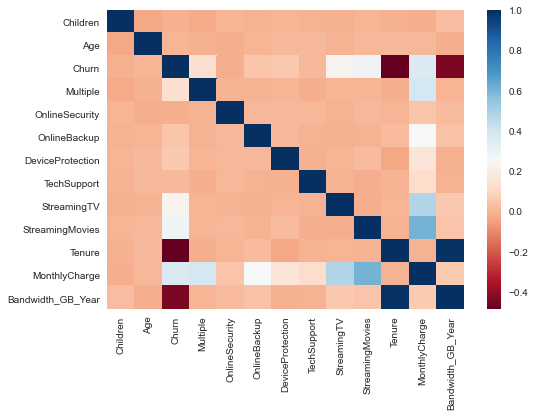

In [15]:
#Create a heatmap of correlations
sns.heatmap(df_corr, xticklabels = df_corr.columns, yticklabels = df_corr.columns, cmap = "RdBu")

In [16]:
#Drop any variables with a correlation > .5
churn_df_drop_corr = churn_df_drop_high_p.drop(['MonthlyCharge'], axis = 1)

#### Variance inflation factors

In [17]:
[4]
#Calculate and print variance inflation factors
churn_df_before = churn_df_drop_corr.drop('Bandwidth_GB_Year', axis = 1)

X1 = sm.tools.add_constant(churn_df_before)
X1 = X1.astype(float)

#Create a series
series_before = pd.Series([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])], index = X1.columns)

#Display the series
print('Data Before')
print('-'*100)
display(series_before)

Data Before
----------------------------------------------------------------------------------------------------


const               16.110979
Children             1.001555
Age                  1.002140
Churn                1.653574
Multiple             1.026562
OnlineSecurity       1.001151
OnlineBackup         1.007141
DeviceProtection     1.003845
TechSupport          1.001742
StreamingTV          1.091168
StreamingMovies      1.139538
Tenure               1.389691
dtype: float64

#### Final model

In [18]:
#Create the final model with any remaining variables from the previous steps
churn_model_final = smf.ols('Bandwidth_GB_Year ~ Churn + Multiple + OnlineSecurity + OnlineBackup+ DeviceProtection + TechSupport + StreamingTV + StreamingMovies + Children + Age + Tenure', data = churn_df).fit()
print(churn_model_final.params)
churn_model_final.summary()

Intercept                   291.742065
Churn[T.True]                82.559484
Multiple[T.True]             66.959326
OnlineSecurity[T.True]       78.416369
OnlineBackup[T.True]         88.784678
DeviceProtection[T.True]     80.028698
TechSupport[T.True]          11.485278
StreamingTV[T.True]         213.065061
StreamingMovies[T.True]     190.057061
Children                     30.665607
Age                          -3.320276
Tenure                       82.681221
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Bandwidth_GB_Year   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 1.077e+05
Date:                Thu, 11 Nov 2021   Prob (F-statistic):               0.00
Time:                        16:36:49   Log-Likelihood:                -67164.
No. Observations:               10000   AIC:                         1.344e+05
Df Residuals:                    9988   BIC:                         1.344e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  291.7421      8.025     36.353      0.000     276.011     307.473
Churn[T.True]               82.5595      5.826     14.172      0.000      71.140      93.979
Multiple[T.True]            66.9593      4.064     16.476      0.000      58.993      74.926
OnlineSecurity[T.True]      78.4164      4.174     18.787      0.000      70.235      86.598
OnlineBackup[T.True]        88.7847      4.033     22.016      0.000      80.880      96.690
DeviceProtection[T.True]    80.0287      4.037     19.823      0.000      72.115      87.942
TechSupport[T.True]         11.4853      4.134      2.779      0.005       3.383      19.588
StreamingTV[T.True]        213.0651      4.178     51.002      0.000     204.876     221.254
StreamingMovies[T.True]    190.0571      4.270     44.512      0.000     181.687     198.427
Children                    30.6656      0.932     32.905      0.000      28.839      32.492
Age                         -3.3203      0.097    -34.335      0.000      -3.510      -3.131
Tenure                      82.6812      0.089    927.545      0.000      82.506      82.856
==============================================================================
Omnibus:                    99366.075   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1390.562
Skew:                           0.590   Prob(JB):                    1.10e-302
Kurtosis:                       1.605   Cond. No.                         283.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## D3. Reduced Multiple Regression Model

In [19]:
print(churn_model_final.params)
churn_model_final.summary()

Intercept                   291.742065
Churn[T.True]                82.559484
Multiple[T.True]             66.959326
OnlineSecurity[T.True]       78.416369
OnlineBackup[T.True]         88.784678
DeviceProtection[T.True]     80.028698
TechSupport[T.True]          11.485278
StreamingTV[T.True]         213.065061
StreamingMovies[T.True]     190.057061
Children                     30.665607
Age                          -3.320276
Tenure                       82.681221
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Bandwidth_GB_Year   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 1.077e+05
Date:                Thu, 11 Nov 2021   Prob (F-statistic):               0.00
Time:                        16:36:49   Log-Likelihood:                -67164.
No. Observations:               10000   AIC:                         1.344e+05
Df Residuals:                    9988   BIC:                         1.344e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  291.7421      8.025     36.353      0.000     276.011     307.473
Churn[T.True]               82.5595      5.826     14.172      0.000      71.140      93.979
Multiple[T.True]            66.9593      4.064     16.476      0.000      58.993      74.926
OnlineSecurity[T.True]      78.4164      4.174     18.787      0.000      70.235      86.598
OnlineBackup[T.True]        88.7847      4.033     22.016      0.000      80.880      96.690
DeviceProtection[T.True]    80.0287      4.037     19.823      0.000      72.115      87.942
TechSupport[T.True]         11.4853      4.134      2.779      0.005       3.383      19.588
StreamingTV[T.True]        213.0651      4.178     51.002      0.000     204.876     221.254
StreamingMovies[T.True]    190.0571      4.270     44.512      0.000     181.687     198.427
Children                    30.6656      0.932     32.905      0.000      28.839      32.492
Age                         -3.3203      0.097    -34.335      0.000      -3.510      -3.131
Tenure                      82.6812      0.089    927.545      0.000      82.506      82.856
==============================================================================
Omnibus:                    99366.075   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1390.562
Skew:                           0.590   Prob(JB):                    1.10e-302
Kurtosis:                       1.605   Cond. No.                         283.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The number of independent variables was reduced from 22 to 11 in the final model.

## E1. Model Comparison
 • The logic of the variable selection technique: The general idea/goal of selecting variables was to limit them to only statistically relevant ones. This was accomplished by looking at how they interacted with each other, how removing them might affect the accuracy of the model, and if their contributions to the model were by chance. After removing any that didn't fit within that goal, we can see that the model's accuracy was largely unchanged, while nearly halving the number of variables.
 
 • The model evaluation metric: The primary evaluator metric for the initial model versus the final model is the adjusted r-squared value. This is one way of looking at the accuracy of your model, with being closer to 1 indicating a better fit. Using the adjusted value helps account for the number of coefficients by considering the complexity of the model [5]. Both models had identically high adjusted r-squared values of .992, indicating both a very accurate model and that the removed variables did not affect its accuracy. Another evaluation method is the condition number, which looks at the robustness of the model if given a different subset of values [5]. Comparing the intial model to the reduced one, there is a significant reduction in the condition number, signaling increased robustness. The final number is still high at 283, suggesting further refinement might be needed.


• A residual plot:

In [20]:
#[6]
#Extract the X and y data from the DataFrame
X = churn_df_before
y = churn_df['Bandwidth_GB_Year']

#Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

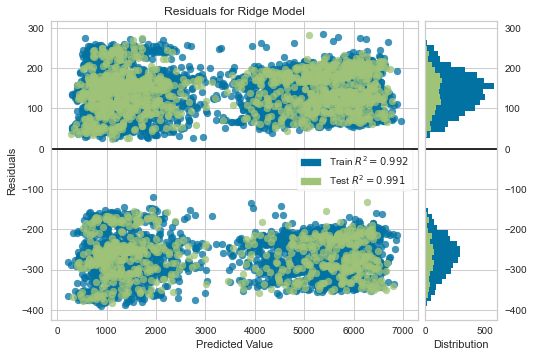

In [21]:
#[6]
#Instantiate the linear model and visualizer
model = Ridge()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data 
g = visualizer.poof()             # Draw/show/poof the data

There is a relatively uniform, bimodal distribution of residuals across the horizontal axis. Uniform distribution is important in verifying that a linear model was the correct model choice. Looking at the actual versus predicted data, there is significant overlap, indicating high accuracy. With the overlap, the residuals are also clearly heteroscedastic.

## E2. Output and Calculations

Outputs and calculations are included in the above code.

## E3. Code

See above for code.

## F1. Results

#### Regression Equations:
Churn: y = 291.74 + 82.56x

Multiple: y = 291.74 + 66.96x

OnlineSecurity: y = 291.74 + 78.42x

OnlineBackup: y = 291.74 + 88.78x

DeviceProtection: y = 291.74 + 80.02x

TechSupport: y = 291.74 + 11.49x

StreamingTV: y = 291.74 + 213.07x

StreamingMovies: y = 291.74 + 190.06x

Children: y = 291.74 + 30.67x

Age: y = 291.73 - 3.32x

Tenure: y = 291.74 + 82.68x

#### Interpretation of coefficients:

In general, most of the coefficients produced from the model are both positive and large. Looking at the specific variables themselves, many are True/False responses. It would make sense then that a "True" response to something like Streaming TV would significantly increase the projected bandwidth used in a year. Out of the three continuous variables remaining, two have strongly positive coefficients. Tenure is likely the most significant one to look at due to its very strong positive correlation, as seen in the above correlation matrix. For every year of tenure, a customer is projected to increase their average bandwidth by 82.68 GB. In contrast, age is the only variable with a negative coefficient, however slight. With each passing year, a customer is projected to decrease their usage by 3.32 GB, possibly relating to older customers using less "tech" in general.


#### Statistical and practical significance of the model:

Given such a high r-squared value of the model, there is significant statistical significance of this model. Using it to predict customer data usage could be a highly effective tool for the company. Having such predictions could be helpful for infrastructure planning and making sure future bandwidth needs of customers can be met.


#### The limitations of the data analysis:

The most significant limitation of this analysis comes from the very high correlation between tenure and bandwidth usage. With a near-perfect linear relationship, the significance of the other variables left after the model reduction comes into question. However, removing everything else might have a cost in terms of the robustness of the model if more data points were to become available. The strong linear relationship between tenure and bandwidth could be a fluke limited to this specific data sampling. If a new sample didn't exhibit the same linearity, the model would be ruined. By having more statistically relevant variables, you increase the strength of the model given different future conditions.

## F2. Recommendations

My recommendation would be for the company to use this model for two things:

1. Use the prediction data to plan for infrastructure needs (cable networks, data warehouses, etc.). This would help ensure enough bandwidth of the whole system so that customers wouldn't need to be throttled.
2. If the company offers tiered bandwidth packages (e.g., 200 GB/month), then they could provide recommendations to customers about what plans might fit their expected usage.

## H. Sources of Third-Party Code
[2] - "How to represent boolean data in a graph" https://stackoverflow.com/questions/43816122/how-to-represent-boolean-data-in-graph

[3]- "Matplotlib scatterplot tutorial and examples" https://stackabuse.com/matplotlib-scatterplot-tutorial-and-examples/

[4] - "Multiple Regression Analysis in Python" https://www.youtube.com/watch?v=8DhvVs59It4

[6] - "Yellowbrick regression visualizer examples" https://www.kaggle.com/kautumn06/yellowbrick-regression-visualizer-examples

## I. Sources
[1] - "Assumptions of linear regression" http://r-statistics.co/Assumptions-of-Linear-Regression.html

[5] - Massaron L, Boschetti A. Regression Analysis with Python. Packt Publishing; 2016.